# Bayesian Logistic Regression with CmdStanPy

TODO: Work in progress 

Authors: Jonah Gabry, Ben Goodrich, Aki Vehtari, Tuomas Sivula

The introduction to Bayesian logistic regression is from a [CRAN vignette](https://cran.r-project.org/web/packages/rstanarm/vignettes/binomial.html) by Jonah Gabry and Ben Goodrich. CRAN vignette was modified to a [R notebook](https://github.com/avehtari/BDA_R_demos/blob/master/demos_rstan/diabetes.Rmd) by Aki Vehtari.  Instead of wells data in CRAN vignette, Pima Indians data is used. The end of the notebook differs significantly from the CRAN vignette.  The R notebook was ported to this Python notebook by Aki Vehtari and Tuomas Sivula.

## Introduction

This vignette explains how to estimate generalized linear models (GLMs) for binary (Bernoulli) response variables using CmdStanPy.

The four steps of a Bayesian analysis are

1. Specify a joint distribution for the outcome(s) and all the unknowns, which typically takes the form of a marginal prior distribution for the unknowns multiplied by a likelihood for the outcome(s) conditional on the unknowns. This joint distribution is proportional to a posterior distribution of the unknowns conditional on the observed data
2. Draw from posterior distribution using Markov Chain Monte Carlo (MCMC).
3. Evaluate how well the model fits the data and possibly revise the model.
4. Draw from the posterior predictive distribution of the outcome(s) given interesting values of the predictors in order to visualize how a manipulation of a predictor affects (a function of) the outcome(s).
This notebook demonstrates Steps 1-3 when the likelihood is the product of conditionally independent binomial distributions (possibly with only one trial per observation).

### Likelihood

For a binomial GLM the likelihood for one observation $y$ can be written as a conditionally binomial PMF $$\binom{n}{y} \pi^{y} (1 - \pi)^{n - y},$$ where $n$ is the known number of trials, $\pi = g^{-1}(\eta)$ is the probability of success and $\eta = \alpha + \mathbf{x}^\top \boldsymbol{\beta}$ is a linear predictor. For a sample of size $N$, the likelihood of the entire sample is the product of $N$ individual likelihood contributions.

Because $\pi$ is a probability, for a binomial model the link function $g$ maps between the unit interval (the support of $\pi$) and the set of all real numbers $\mathbb{R}$. When applied to a linear predictor $\eta$ with values in $\mathbb{R}$, the inverse link function $g^{-1}(\eta)$ therefore returns a valid probability between 0 and 1.

The two most common link functions used for binomial GLMs are the logit and probit functions. With the logit (or log-odds) link function $g(x) = \ln{\left(\frac{x}{1-x}\right)}$, the likelihood for a single observation becomes

$$\binom{n}{y}\left(\text{logit}^{-1}(\eta)\right)^y \left(1 - \text{logit}^{-1}(\eta)\right)^{n-y} = \binom{n}{y} \left(\frac{e^{\eta}}{1 + e^{\eta}}\right)^{y} \left(\frac{1}{1 + e^{\eta}}\right)^{n - y}$$

and the probit link function $g(x) = \Phi^{-1}(x)$ yields the likelihood

$$\binom{n}{y} \left(\Phi(\eta)\right)^{y} \left(1 - \Phi(\eta)\right)^{n - y},$$

where $\Phi$ is the CDF of the standard normal distribution. The differences between the logit and probit functions are minor and -- if, as rstanarm does by default, the probit is scaled so its slope at the origin matches the logit's -- the two link functions should yield similar results. Unless the user has a specific reason to prefer the probit link, we recommend the logit simply because it will be slightly faster and more numerically stable.

In theory, there are infinitely many possible link functions, although in practice only a few are typically used. 


### Priors

A full Bayesian analysis requires specifying prior distributions $f(\alpha)$ and $f(\boldsymbol{\beta})$ for the intercept and vector of regression coefficients. 

As an example, suppose we have $K$ predictors and believe --- prior to seeing the data --- that $\alpha, \beta_1, \dots, \beta_K$ are as likely to be positive as they are to be negative, but are highly unlikely to be far from zero. These beliefs can be represented by normal distributions with mean zero and a small scale (standard deviation).

If, on the other hand, we have less a priori confidence that the parameters will be close to zero then we could use a larger scale for the normal distribution and/or a distribution with heavier tails than the normal like the Student's $t$ distribution.

### Posterior

With independent prior distributions, the joint posterior distribution for $\alpha$ and $\boldsymbol{\beta}$ is proportional to the product of the priors and the $N$ likelihood contributions:

$$f\left(\alpha,\boldsymbol{\beta} | \mathbf{y},\mathbf{X}\right) \propto f\left(\alpha\right) \times \prod_{k=1}^K f\left(\beta_k\right) \times \prod_{i=1}^N { g^{-1}\left(\eta_i\right)^{y_i} \left(1 - g^{-1}\left(\eta_i\right)\right)^{n_i-y_i}}.$$

This is posterior distribution that CmdStanPy will draw from when using MCMC.

## Logistic Regression Example

When the logit link function is used the model is often referred to as a logistic regression model (the inverse logit function is the CDF of the standard logistic distribution). As an example, here we will show how to carry out a analysis for Pima Indians data set similar to analysis from Chapter 5.4 of Gelman and Hill (2007) using CmdStanPy.

In [1]:
import os, sys

import arviz as az
import numpy as np
import pandas as pd

# import stan interface
from cmdstanpy import CmdStanModel

# add utilities directory to path
# so we can import check_utility
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
from check_utility import check_div, check_energy, check_treedepth

az.style.use('arviz-white')

### Data

First we load and pre-process data.

In [2]:
# load data
data_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'diabetes.csv'
    )
)
data = pd.read_csv(data_path)
# print some basic info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
# preview some first rows
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# some summary
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Preprocess data

In [5]:
# modify the data column names slightly for easier typing
# rename DiabetesPedigreeFunction to dpf
data.rename(columns={'DiabetesPedigreeFunction': 'dpf'}, inplace=True)
# make lower
data.rename(columns=lambda old_name: old_name.lower(), inplace=True)

In [6]:
# removing those observation rows with 0 in selected variables
normed_predictors = [
    'glucose',
    'bloodpressure',
    'skinthickness',
    'insulin',
    'bmi'
]
data = data[(data[normed_predictors] != 0).all(axis=1)]

In [7]:
# scale the covariates for easier comparison of coefficient posteriors
# N.B. int columns turn into floats
data.iloc[:,:-1] -= data.iloc[:,:-1].mean()
data.iloc[:,:-1] /= data.iloc[:,:-1].std()

/tmp/ipykernel_15399/3539175312.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3     -2.30102
4     -3.30102
6     -0.30102
8     -1.30102
13    -2.30102
        ...   
753   -3.30102
755   -2.30102
760   -1.30102
763    6.69898
765    1.69898
Name: pregnancies, Length: 392, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:,:-1] -= data.iloc[:,:-1].mean()
/tmp/ipykernel_15399/3539175312.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3     -33.627551
4      14.372449
6     -44.627551
8      74.372449
13     66.372449
         ...    
753    58.372449
755     5.372449
760   -34.627551
763   -21.627551
765    -1.627551
Name: glucose, Length: 392, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:,:-1] -= da

In [8]:
# preview some first rows againg
data.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,dpf,age,outcome
3,-0.716511,-1.089653,-0.373178,-0.584363,-0.522175,-0.709514,-1.030559,-0.967063,0
4,-1.027899,0.465719,-2.453828,0.556709,0.100502,1.424909,5.108582,0.209318,1
6,-0.093734,-1.446093,-1.653578,0.271441,-0.572662,-0.296859,-0.796108,-0.476904,1
8,-0.405123,2.409934,-0.053078,1.507603,3.255961,-0.368007,-1.056609,2.169953,1
13,-0.716511,2.150705,-0.853328,-0.584363,5.805571,-0.424924,-0.361940,2.758143,1


In [9]:
# preparing the inputs
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [10]:
# get shape into variables
n, p = X.shape
print('number of observations = {}'.format(n))
print('number of predictors = {}'.format(p))

number of observations = 392
number of predictors = 8


### Stan model code for logistic regression

Logistic regression with Student's $t$ prior as discussed above.

In [11]:
with open('logistic_t.stan') as file:
    print(file.read())

/**
 * Logistic regression t-prior
 *
 * Priors:
 *     weights - student t
 *     intercept - student t
 */
data {
    int<lower=0> n;                      // number of data points
    int<lower=1> d;                      // explanatory variable dimension
    matrix[n, d] X;                      // explanatory variable
    array[n] int<lower=0, upper=1> y;    // response variable
    int<lower=1> p_alpha_df;             // prior degrees of freedom for alpha
    real p_alpha_loc;                    // prior location for alpha
    real<lower=0> p_alpha_scale;         // prior scale for alpha
    int<lower=1> p_beta_df;              // prior degrees of freedom for beta
    real p_beta_loc;                     // prior location for beta
    real<lower=0> p_beta_scale;          // prior scale for beta
}




parameters {
    real alpha;      // intercept
    vector[d] beta;  // explanatory variable weights
}
transformed parameters {
    // linear predictor
    vector[n] eta;
    eta = alpha

In [12]:
model = CmdStanModel(stan_file='logistic_t.stan')

### Set priors and sample from the posterior

Here we'll use a Student t prior with 7 degrees of freedom and a scale of 2.5, which, as discussed above, is a reasonable default prior when coefficients should be close to zero but have some chance of being large. CmdStanPy returns the posterior distribution for the parameters describing the uncertainty related to unknown parameter values.

In [13]:
data1 = dict(
    n=n,
    d=p,
    X=X,
    y=y,
    p_alpha_df=7,
    p_alpha_loc=0,
    p_alpha_scale=2.5,
    p_beta_df=7,
    p_beta_loc=0,
    p_beta_scale=2.5
)
fit1 = model.sample(data=data1, seed=74749)
idata_t = az.from_cmdstanpy(fit1)

11:15:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:15:56 - cmdstanpy - INFO - CmdStan done processing.


### Inspect the resulting posterior

Check n_effs and Rhats

In [14]:
az.summary(idata_t, var_names=['alpha', 'beta'], kind='diagnostics')

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.002,5029.0,3276.0,1.0
beta[0],0.003,0.003,3530.0,3136.0,1.0
beta[1],0.003,0.002,3995.0,3275.0,1.0
beta[2],0.002,0.002,4834.0,3061.0,1.0
beta[3],0.003,0.003,3456.0,2771.0,1.0
beta[4],0.003,0.002,3753.0,3300.0,1.0
beta[5],0.003,0.003,3277.0,2917.0,1.0
beta[6],0.002,0.003,5797.0,3041.0,1.0
beta[7],0.003,0.003,3151.0,3009.0,1.0


n_effs are high and Rhats<1.1, which is good.

Next we check divergences, E-BMFI and treedepth exceedences as explained in [Robust Statistical Workflow with PyStan Case Study](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html) by Michael Betancourt.

In [15]:
check_div(idata_t)
check_energy(idata_t)
check_treedepth(idata_t)

We don't get any warning message, so everything is fine based on these diagnostics and we can proceed with our analysis.

Visualise the marginal posterior distributions of each parameter

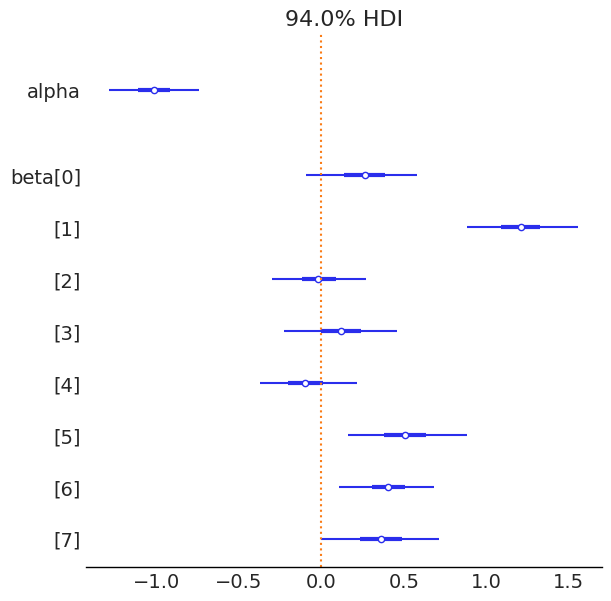

In [16]:
ax = az.plot_forest(idata_t,
               combined=True,
               var_names=['alpha', 'beta'],
               )
ax[0].axvline(0, color="C1", linestyle="dotted");

We can use Pareto smoothed importance sampling leave-one-out cross-validation to estimate the predictive performance.

In [17]:
loo_t = az.loo(idata_t)
loo_t

Computed from 4000 posterior samples and 392 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -182.33    11.99
p_loo       10.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      392  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Alternative horseshoe prior on weights

In this example, with $n \gg p$ the difference is small, and thus we don’t expect much difference with a different prior and horseshoe prior is usually more useful for $n<p$.

The global scale parameter for horseshoe prior is chosen as recommended by Juho Piironen and Aki Vehtari (2017). On the Hyperprior Choice for the Global Shrinkage Parameter in the Horseshoe Prior. Journal of Machine Learning Research: Workshop and Conference Proceedings (AISTATS 2017 Proceedings), accepted for publication. [arXiv preprint arXiv:1610.05559](http://arxiv.org/abs/1610.05559).

In [18]:
with open('logistic_hs.stan') as file:
    print(file.read())

/**
 * Logistic regression HS-prior
 *
 * Priors:
 *     weights - hierarchical shrinkage
 *     intercept - student t
 */

data {
    int<lower=0> n;                     // number of data points
    int<lower=1> d;                     // explanatory variable dimension
    matrix[n, d] X;                     // explanatory variable
    array[n] int<lower=0, upper=1> y;   // response variable
    int<lower=1> p_alpha_df;            // prior alpha degrees of freedom
    real p_alpha_loc;                   // prior alpha location
    real<lower=0> p_alpha_scale;        // prior scale alpha
    int<lower=1> p_beta_df;             // prior beta degrees of freedom
    int<lower=1> p_beta_global_df;      // prior beta global degrees of freedom
    real<lower=0> p_beta_global_scale;  // prior beta global scale
}

parameters {

    // intercept
    real alpha;

    // auxiliary variables for the variance parameters
    vector[d] z;
    vector<lower=0>[d] lambda_r1;
    vector<lower=0>[d] lambda

In [19]:
model = CmdStanModel(stan_file='logistic_hs.stan')

In [20]:
p0 = 2 # prior guess for the number of relevant variables
tau0 = p0 / (p - p0) * 1 / np.sqrt(n)
data2 = dict(
    n=n,
    d=p,
    X=X,
    y=y,
    p_alpha_df=7,
    p_alpha_loc=0,
    p_alpha_scale=2.5,
    p_beta_df=1,
    p_beta_global_df=1,
    p_beta_global_scale=tau0
)
fit2 = model.sample(data=data2, seed=74749)
idata_hs = az.from_cmdstanpy(fit2)

11:15:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:16:01 - cmdstanpy - INFO - CmdStan done processing.
11:16:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: bernoulli_logit_lpmf: Logit transformed probability parameter[1] is -nan, but must be not nan! (in 'logistic_hs.stan', line 64, column 4 to column 29)
Exception: bernoulli_logit_lpmf: Logit transformed probability parameter[1] is -nan, but must be not nan! (in 'logistic_hs.stan', line 64, column 4 to column 29)
Exception: bernoulli_logit_lpmf: Logit transformed probability parameter[1] is -nan, but must be not nan! (in 'logistic_hs.stan', line 64, column 4 to column 29)
Consider re-running with show_console=True if the above output is unclear!
11:16:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see furthe

We see that the horseshoe prior has shrunk the posterior distribution of irrelevant features closer to zero, without affecting the posterior distribution of the relevant features.

In [21]:
az.summary(idata_hs, var_names=['alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.973,0.141,-1.230,-0.704,0.002,0.003,4363.0,2806.0,1.0
beta[0],0.185,0.174,-0.084,0.510,0.004,0.002,1592.0,2761.0,1.0
beta[1],1.138,0.163,0.842,1.444,0.003,0.002,4221.0,3439.0,1.0
beta[2],0.014,0.095,-0.186,0.205,0.001,0.002,4643.0,3782.0,1.0
beta[3],0.103,0.146,-0.114,0.416,0.003,0.002,2547.0,3390.0,1.0
beta[4],-0.021,0.095,-0.238,0.149,0.001,0.002,4373.0,3546.0,1.0
beta[5],0.394,0.194,-0.015,0.703,0.004,0.003,2170.0,1258.0,1.0
beta[6],0.289,0.162,-0.020,0.549,0.004,0.003,1733.0,1142.0,1.0
beta[7],0.318,0.198,-0.038,0.644,0.005,0.003,1778.0,1307.0,1.0


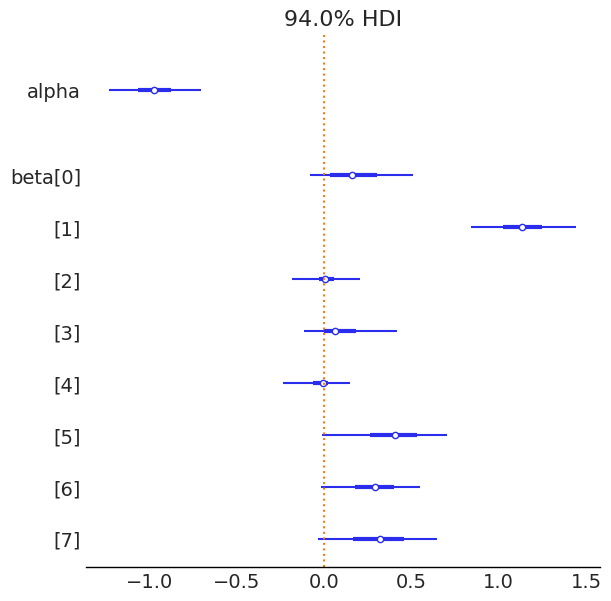

In [22]:
ax = az.plot_forest(idata_hs,
               combined=True,
               var_names=['alpha', 'beta'],
               )
ax[0].axvline(0, color="C1", linestyle="dotted");

We compute LOO also for the model with Horseshoe prior. Expected log predictive density is higher, but not significantly. This is not surprising as this is a easy data with $n \gg p$.

In [23]:
loo_hs = az.loo(idata_hs)
loo_hs

Computed from 4000 posterior samples and 392 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -181.84    11.10
p_loo        9.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      392  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [24]:
elpd_diff = loo_hs.loo_i - loo_t.loo_i
elpd_diff_se = np.sqrt(np.var(elpd_diff, ddof=1)*n)
elpd_diff = np.sum(elpd_diff)
print(f'elpd_diff: {elpd_diff:.4} (SE {elpd_diff_se:.3})')

elpd_diff: 0.4864 (SE 1.53)
